<a href="https://colab.research.google.com/github/arvind2047/gl_capstone/blob/interim_week1_workarea/GL_AIML_Capstone_Sep2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CAPSTONE PROJECT: AUTOMATIC TICKET ASSIGNMENT**


#### Problem Statement:

Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service. 

Additional effort needed for Functional teams to re-assign to right functional groups. During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service. Guided by powerful AI techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.

#### The objective of the project is,
 Learn how to use different classification models.

 Use transfer learning to use pre-built models. 

 Learn to set the optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc.

 Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.


In [1]:
#Importing libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import scipy.stats as st

import keras 
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setup project path:
import os
os.chdir('/content/drive/My Drive/GL AIML Capstone')
os.getcwd()

'/content/drive/My Drive/GL AIML Capstone'

In [37]:
# read and load data
incidents = pd.read_excel("input_data.xlsx")
incidents.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [38]:
## basic info
print('Number of data items',incidents.shape[0],'\n')
incidents.info()

Number of data items 8500 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [39]:
incidents.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


*   There are empty 'Description' and 'Short Description' rows
*   There are 74 unique assignment groups - GRP_0 the most frequent item with 3976 entries


## Data cleaning

In [40]:
## find NA
incidents[incidents.isna().any(axis=1)]

,Short description,Description,Caller,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [41]:
# drop nulls
incidents.dropna(inplace=True)
print('Removing rows with null values')
print(incidents.shape)

Removing rows with null values
(8491, 4)


In [42]:
# drop duplicates
print('Removing',incidents[incidents.duplicated()].shape[0],'duplicate rows')
incidents = incidents.drop_duplicates()
print(incidents.shape)

Removing 83 duplicate rows
(8408, 4)


In [43]:
incidents.apply(lambda x: x.astype(str).str.lower())

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,grp_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,grp_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,grp_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,grp_0
4,skype error,skype error,owlgqjme qhcozdfx,grp_0
...,...,...,...,...
8495,emails not coming in from zz mail,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,avglmrts vhqmtiua,grp_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,grp_0
8497,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,grp_0
8498,machine nã£o estã¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,grp_62


In [44]:
import re
# Removing special characters
incidents['Short description']  = incidents['Short description'].map(lambda x: re.sub(r'\W', ' ', x))
incidents['Description']        = incidents['Description'].map(lambda x: re.sub(r'\W', ' ', x))

In [45]:
incidents.head()

,Short description,Description,Caller,Assignment group
0,login issue,verified user details employee manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,received from hmjdrvpb komuaywn gmail com...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,received from eylqgodm ybqkwiam gmail com...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


## Exploratory Data Analysis

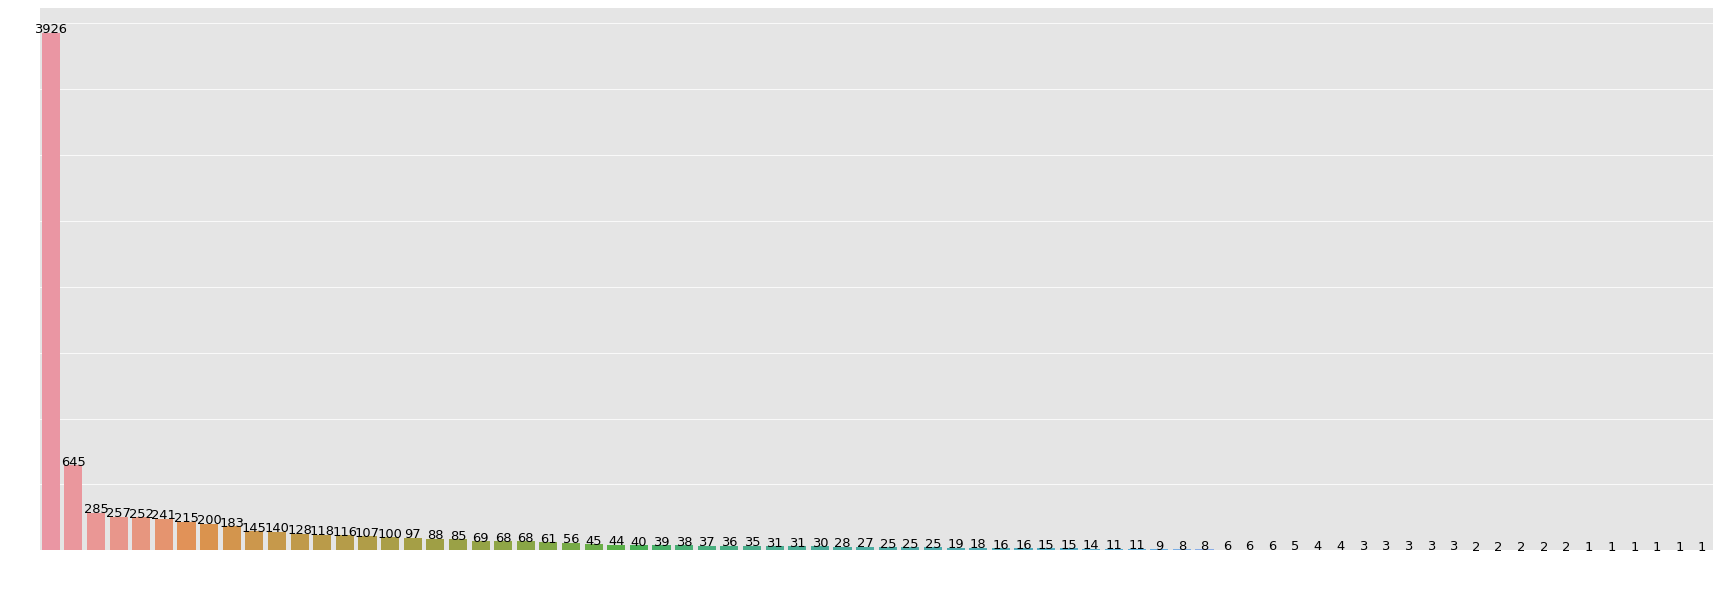

In [46]:
## Group by Categories
assgn = incidents['Assignment group'].value_counts()
plt.figure(figsize=(30,10))
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
cntplot = sns.barplot(x=assgn.index,y=assgn.values)
cntplot.set_xticklabels(cntplot.get_xticklabels(),rotation=90)
for i in range(len(assgn)):
  cntplot.text(i, assgn.values[i], assgn.values[i], color='black', ha='center', fontsize=13)
plt.show()

We can see the data is extremely unbalanced towards GRP_0 and GRP_8 with their data occupying 55% of the available data. Let us try to observe patterns with length of data.

In [47]:
incidents['sdesc_len'] = incidents['Short description'].str.len()
incidents['desc_len'] = incidents['Description'].str.len()

Text(0.5, 1.0, 'Distribution of length of short descriptions')

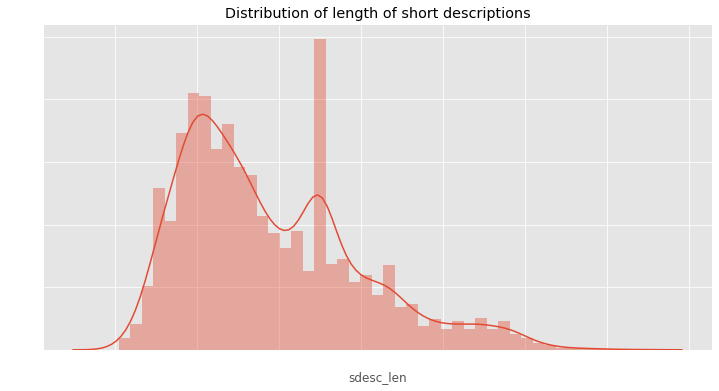

In [48]:
plt.figure(figsize=(12,6))
sns.distplot(incidents['sdesc_len']).set_title('Distribution of length of short descriptions')

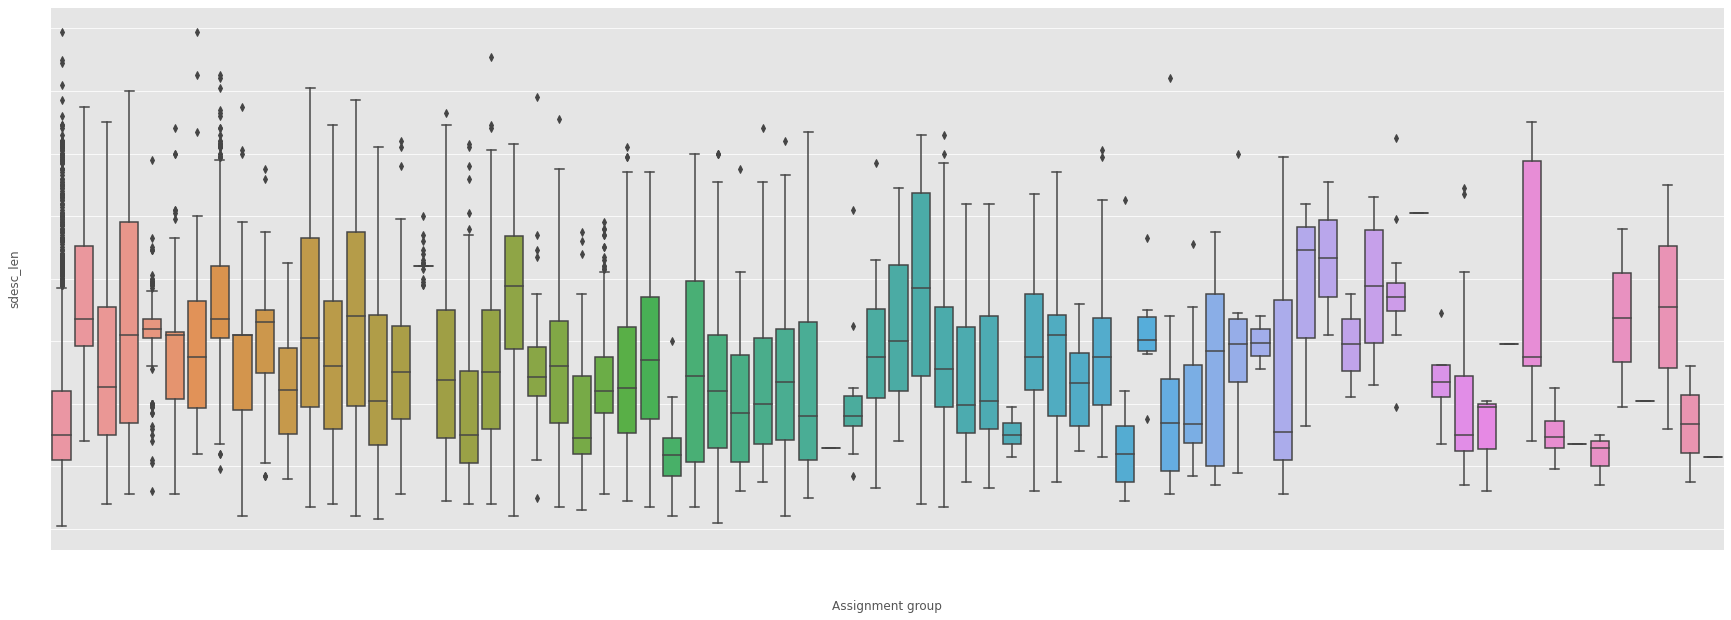

In [49]:
plt.figure(figsize=(30,10))
lengths = sns.boxplot(data=incidents, x='Assignment group', y='sdesc_len')
lengths.set_xticklabels(lengths.get_xticklabels(),rotation=90)
plt.show()

We can see most of the short description are around 30 to 80 characters long with mean length around 50. However, we can see data for certain groups are either on the upper range (GRP_20, GRP_1, GRP_56), while some have a characteristic to have lower lengths (GRP_0, GRP_48, GRP_19).

Text(0.5, 1.0, 'Distribution of length of descriptions')

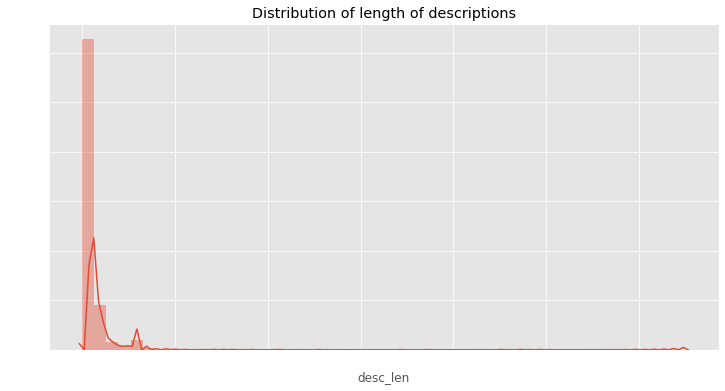

In [50]:
plt.figure(figsize=(12,6))
sns.distplot(incidents['desc_len']).set_title('Distribution of length of descriptions')

The distribution of description lengths is extremely skewed, let us try to omit the tail and focus the major portion from the right skewed graph.

In [51]:
incidents['desc_len'].describe(percentiles=[0.25,0.5,0.6,0.7,0.75,0.8,0.9,0.95])

count     8408.00000
mean       205.55471
std        522.22436
min          1.00000
25%         42.00000
50%        106.00000
60%        121.00000
70%        171.00000
75%        203.00000
80%        244.00000
90%        397.00000
95%        680.65000
max      13001.00000
Name: desc_len, dtype: float64

In [52]:
len(incidents[incidents['desc_len'] > 680])

421

95% of the descriptions have length lesser than 680 characters, lets plot the distribution for them.

Text(0.5, 1.0, 'Distribution of length of descriptions')

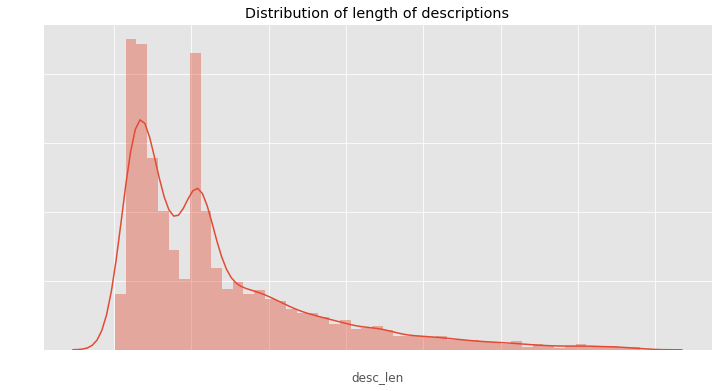

In [53]:
incidents_95 = incidents[incidents['desc_len'] < incidents['desc_len'].quantile(0.95)]
plt.figure(figsize=(12,6))
sns.distplot(incidents_95['desc_len']).set_title('Distribution of length of descriptions')

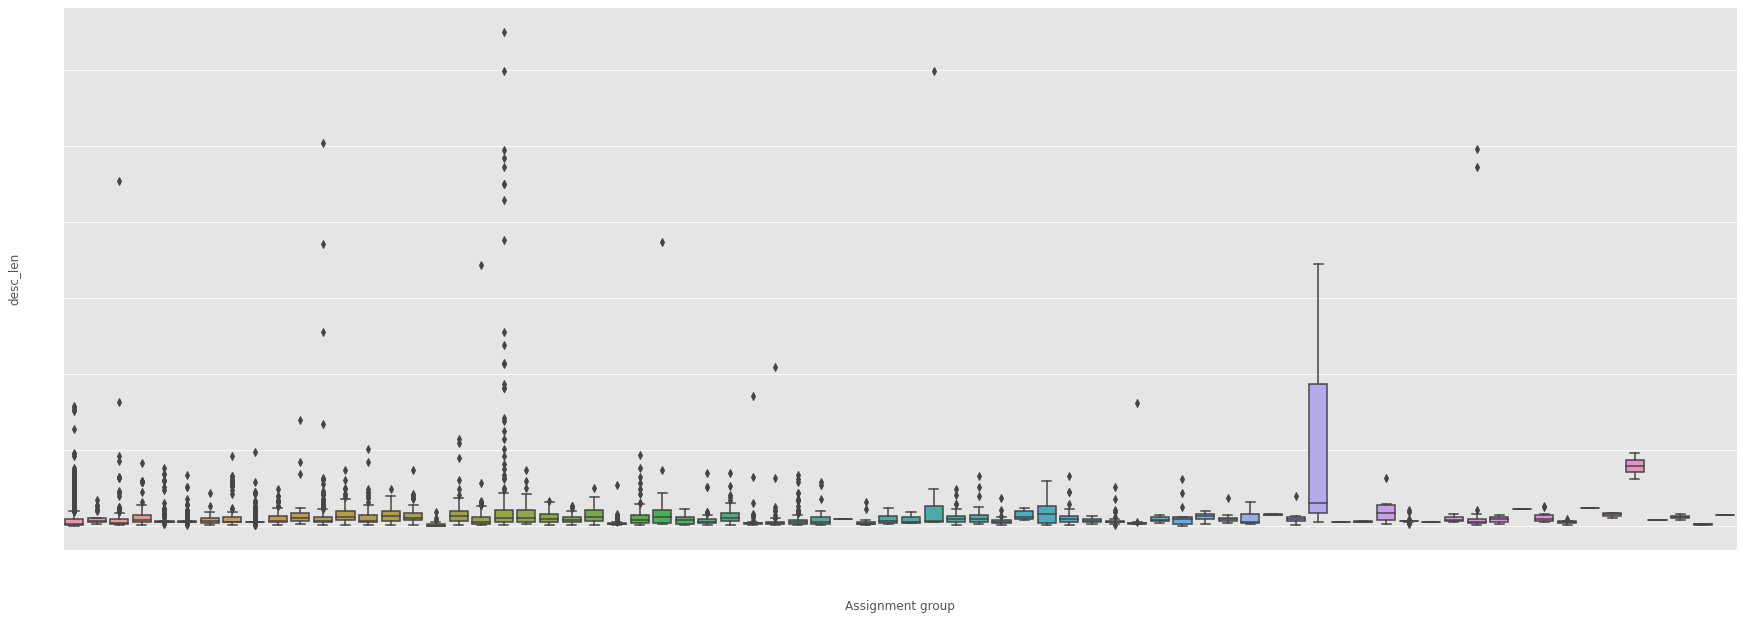

In [54]:
plt.figure(figsize=(30,10))
lengths = sns.boxplot(data=incidents, x='Assignment group', y='desc_len')
lengths.set_xticklabels(lengths.get_xticklabels(),rotation=90)
plt.show()

We can see clearly GRP_56 is dominating with long descriptions. We will again try to restrict data of only particular limit.

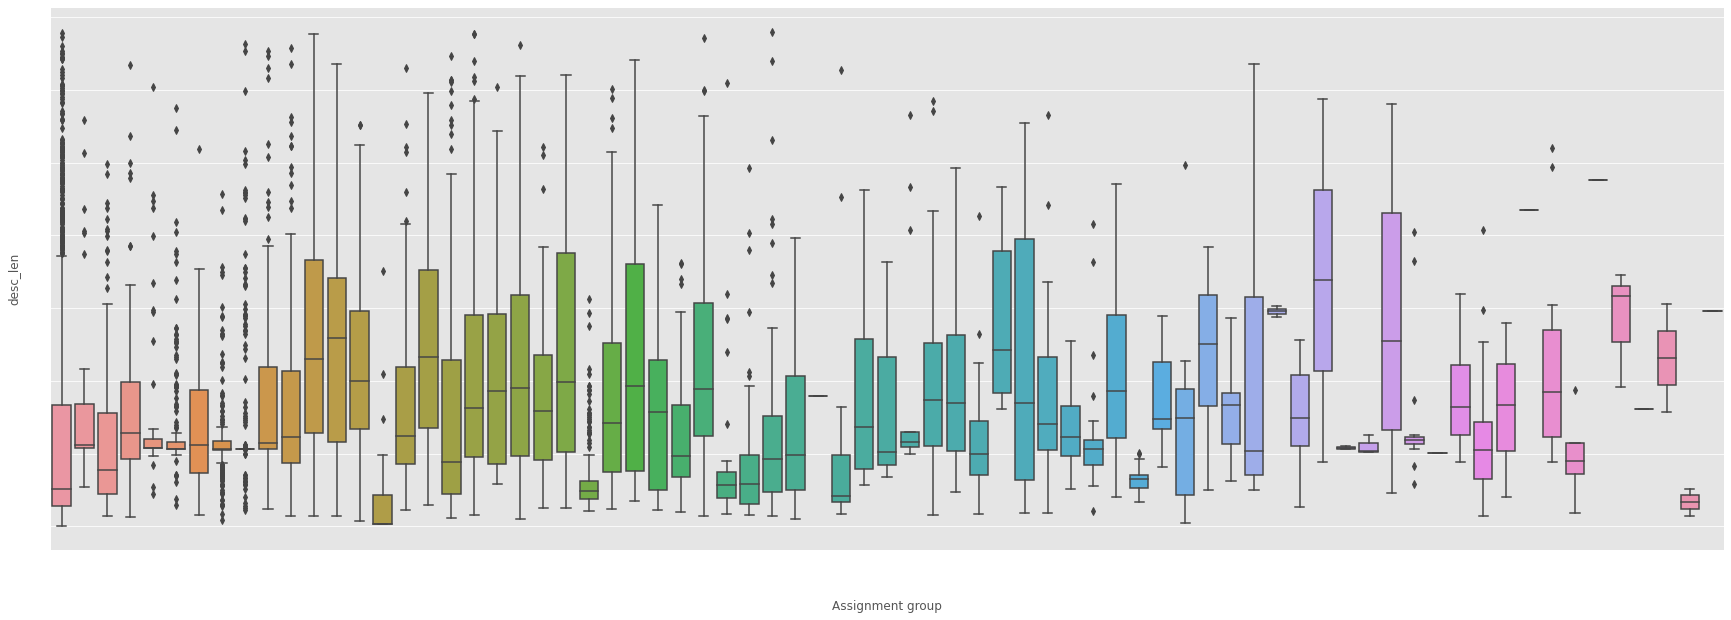

In [55]:
plt.figure(figsize=(30,10))
lengths = sns.boxplot(data=incidents_95, x='Assignment group', y='desc_len')
lengths.set_xticklabels(lengths.get_xticklabels(),rotation=90)
plt.show()

Again, we are seeing a pattern with GRP_56 and GRP_43 typically having longer lengths in contrast to most other groups having lengths below 200 characters. Let us plot the mean lengths of description columns.

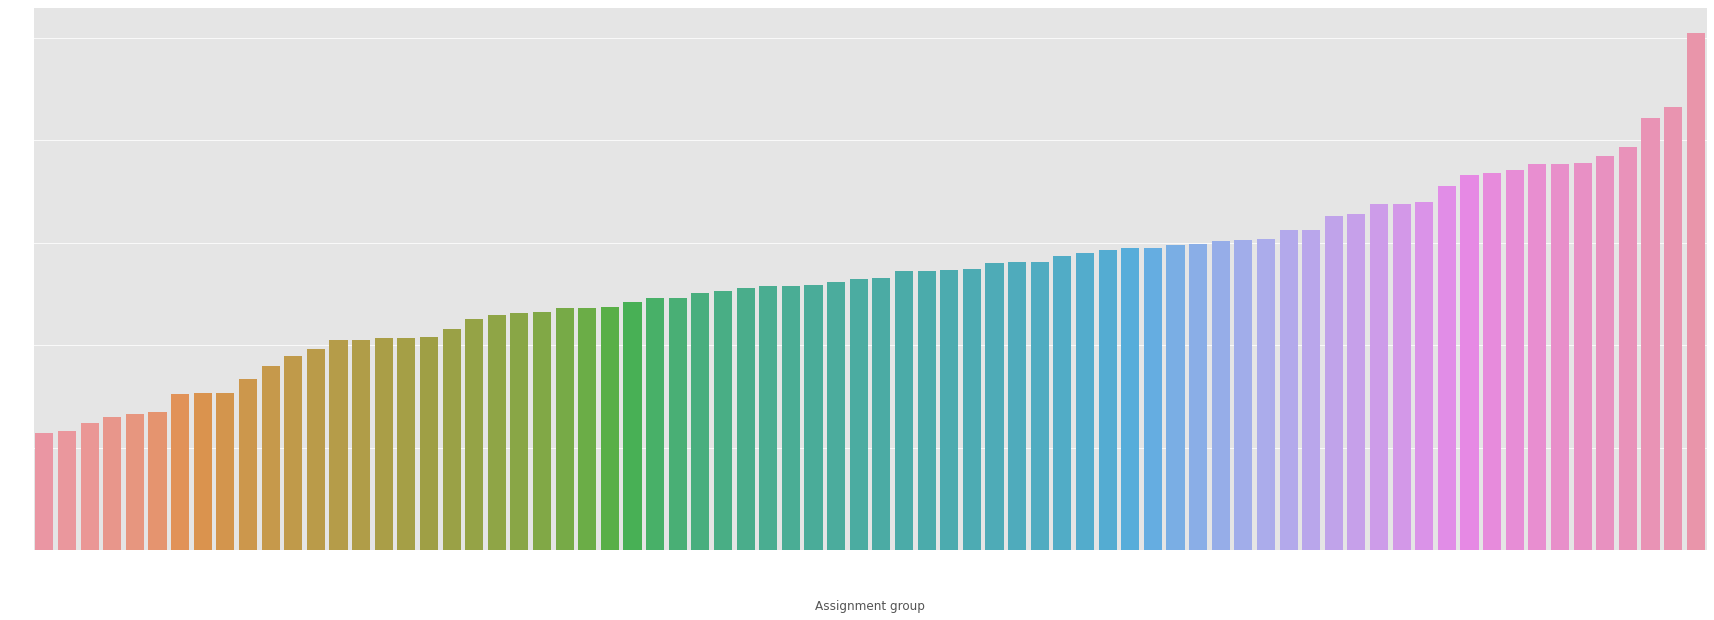

In [56]:
plt.figure(figsize=(30,10))
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plot_meansdesc_len=sns.barplot(x=incidents.groupby(['Assignment group']).mean()['sdesc_len'].sort_values().index,
                               y=incidents.groupby(['Assignment group']).mean()['sdesc_len'].sort_values().values)
plot_meansdesc_len.set_xticklabels(plot_meansdesc_len.get_xticklabels(),rotation=90)
plt.show()

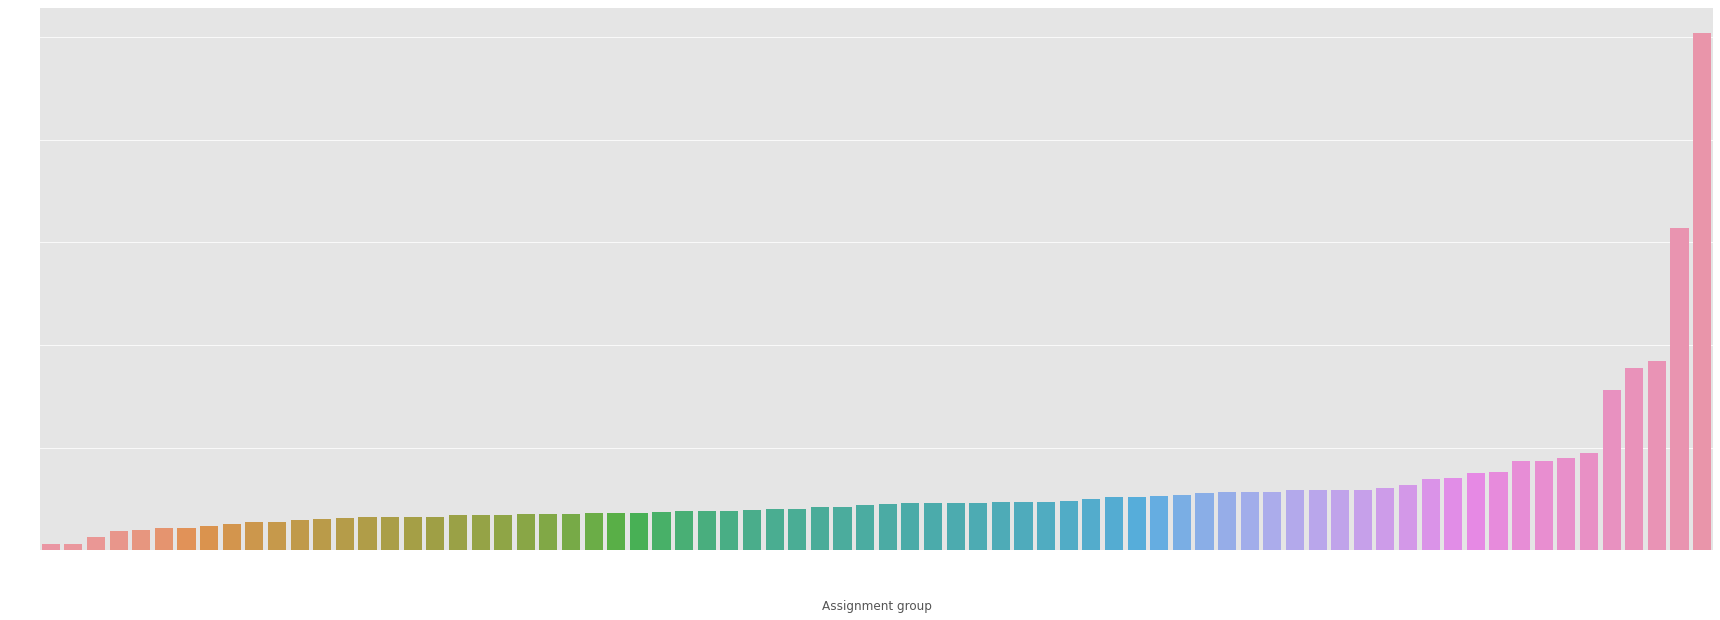

In [57]:
plt.figure(figsize=(30,10))
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plot_meandesc_len=sns.barplot(x=incidents.groupby(['Assignment group']).mean()['desc_len'].sort_values().index,
                               y=incidents.groupby(['Assignment group']).mean()['desc_len'].sort_values().values)
plot_meandesc_len.set_xticklabels(plot_meandesc_len.get_xticklabels(),rotation=90)
plt.show()

## Further data cleaning

In [58]:
!pip install langdetect
!pip install googletrans

In [59]:
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
from langdetect import detect
import googletrans
from googletrans import Translator
from collections import Counter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [60]:
stop_words=set(stopwords.words('english'))

In [61]:
translator = Translator()
print(translator.translate('netweaver funktioniert nicht mehr').text)

netweaver has stopped working


In [62]:
incidents.head()

,Short description,Description,Caller,Assignment group,sdesc_len,desc_len
0,login issue,verified user details employee manager na...,spxjnwir pjlcoqds,GRP_0,11,206
1,outlook,received from hmjdrvpb komuaywn gmail com...,hmjdrvpb komuaywn,GRP_0,7,194
2,cant log in to vpn,received from eylqgodm ybqkwiam gmail com...,eylqgodm ybqkwiam,GRP_0,18,87
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,29,29
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,12,12


In [63]:
incidents['desc_lang'] = ''
desc_lang=[]
desc_trans=[]
for i,row in incidents.iterrows():
    try:
        language = detect(row['Description'])
        trans = translator.translate(row['Description']).text if language != 'en' else row['Description']
    except:
        language = "error"
        print("This row throws an error:", row['Description'])
    desc_lang.append(language)
    desc_trans.append(trans)
incidents['desc_lang']=desc_lang
incidents['Description']=desc_trans

This row throws an error:  86  
This row throws an error:      
This row throws an error:   


In [64]:
incidents['desc_lang'].value_counts()[incidents['desc_lang'].value_counts()>50]

en    6948
de     380
af     261
it     151
fr     108
no      92
sv      82
nl      64
es      56
da      51
Name: desc_lang, dtype: int64

In [65]:
desc_lang_post=[]
for i,row in incidents.iterrows():
    try:
        language = detect(row['Description'])
    except:
        language = "error"
        print("This row throws an error:", row['Description'])
    desc_lang_post.append(language)
Counter(desc_lang_post)

Counter({'af': 267,
         'ca': 39,
         'cs': 2,
         'cy': 14,
         'da': 51,
         'de': 122,
         'en': 7247,
         'es': 58,
         'et': 3,
         'fi': 8,
         'fr': 106,
         'hr': 4,
         'hu': 1,
         'id': 6,
         'it': 151,
         'lt': 2,
         'lv': 1,
         'nl': 51,
         'no': 85,
         'pl': 27,
         'pt': 32,
         'ro': 20,
         'sk': 2,
         'sl': 7,
         'so': 2,
         'sq': 3,
         'sv': 78,
         'sw': 2,
         'tl': 13,
         'tr': 4})

In [66]:
incidents['sdesc_lang'] = ''
sdesc_lang=[]
sdesc_trans=[]
for i,row in incidents.iterrows():
    try:
        language = detect(row['Short description'])
        trans = translator.translate(row['Short description']).text if language != 'en' else row['Short description']
    except:
        language = "error"
        print("This row throws an error:", row['Short description'])
    sdesc_lang.append(language)
    sdesc_trans.append(trans)
incidents['sdesc_lang']=sdesc_lang
incidents['Short description']=sdesc_trans

This row throws an error:                    


In [67]:
incidents['sdesc_lang'].value_counts()[incidents['sdesc_lang'].value_counts()>50]

en    5944
af     494
de     366
it     297
fr     260
no     178
nl     153
da     108
sv     102
ca      96
es      85
pl      55
Name: sdesc_lang, dtype: int64

In [68]:
def text_to_wordlist(text, remove_stop_words=True, lemma_words=True):
    # Clean the text, with the option to remove stop_words and to stem words.

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemma_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer()
        lemma_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemma_words)
    
    # Return a list of words
    return(text)

In [69]:
desc_tokens=[]
for i,row in incidents.iterrows():
    tokens = ' '.join(word_tokenize(text_to_wordlist(row['Description'])))
    desc_tokens.append(tokens)
incidents['Description']=desc_tokens

In [70]:
sdesc_tokens=[]
for i,row in incidents.iterrows():
    tokens = ' '.join(word_tokenize(text_to_wordlist(row['Short description'])))
    sdesc_tokens.append(tokens)
incidents['Short description']=sdesc_tokens

In [73]:
incidents['Group id'] = incidents['Assignment group'].factorize()[0]
incidents.head()

,Short description,Description,Caller,Assignment group,sdesc_len,desc_len,desc_lang,sdesc_lang,Group id
0,login issue,verified user detail employee manager name che...,spxjnwir pjlcoqds,GRP_0,11,206,en,fr,0
1,outlook,received hmjdrvpb komuaywn gmail com hello tea...,hmjdrvpb komuaywn,GRP_0,7,194,en,et,0
2,cant log vpn,received eylqgodm ybqkwiam gmail com hi can no...,eylqgodm ybqkwiam,GRP_0,18,87,en,en,0
3,unable access hr tool page,unable access hr tool page,xbkucsvz gcpydteq,GRP_0,29,29,en,en,0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,12,12,no,no,0


In [74]:
group_id_df = incidents[['Assignment group', 'Group id']].drop_duplicates().sort_values('Group id')

In [75]:
group_to_id = dict(group_id_df.values)
id_to_group = dict(group_id_df[['Group id', 'Assignment group']].values)

In [76]:
tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(incidents['Short description'])
word_index = tokenizer.word_index
print(word_index)

{'<UNK>': 1, 'job': 2, 'password': 3, '00': 4, 'scheduler': 5, 'erp': 6, '2016': 7, 'failed': 8, 'tool': 9, 'unable': 10, 'reset': 11, 'sid': 12, 'issue': 13, 'account': 14, '10': 15, 'access': 16, '09': 17, 'outlook': 18, 'hostname': 19, 'company': 20, 'login': 21, '08': 22, '34': 23, 'working': 24, 'error': 25, 'locked': 26, 'user': 27, 'ticket': 28, 'need': 29, 'update': 30, 'please': 31, 'vpn': 32, 'skype': 33, 'engineering': 34, 'email': 35, 'since': 36, 'crm': 37, 'et': 38, 'window': 39, '1': 40, 'printer': 41, 'usa': 42, 'problem': 43, 'network': 44, 'new': 45, 'outage': 46, 'server': 47, 'management': 48, 'unlock': 49, 'collaboration': 50, 'platform': 51, 'can': 52, 'not': 53, 'open': 54, 'connect': 55, '02': 56, 'help': 57, 'request': 58, '23': 59, '11': 60, 'system': 61, 'software': 62, 'site': 63, '15': 64, 'log': 65, '22': 66, 'eu': 67, 'circuit': 68, 'change': 69, 'able': 70, 'hr': 71, 'abended': 72, 'com': 73, '2': 74, 'pc': 75, 'order': 76, '16': 77, 'plant': 78, 'call':

In [77]:
len(word_index)

7068